# Harry Mardika

# Data Preparation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2M
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
import os, cv2, multiprocessing, logging, random, shutil

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
base_dir = '/content/drive/MyDrive/assets/trash-data'
other = os.path.join(base_dir,'other')
recycle = os.path.join(base_dir,'recycle')

In [4]:
len(os.listdir(other)),len(os.listdir(recycle))

(10229, 9999)

In [5]:
def display_random_images(directory, num_images=2):
  image_files = os.listdir(directory)
  random_images = random.sample(image_files, min(num_images, len(image_files)))

  for image_file in random_images:
    image_path = os.path.join(directory, image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

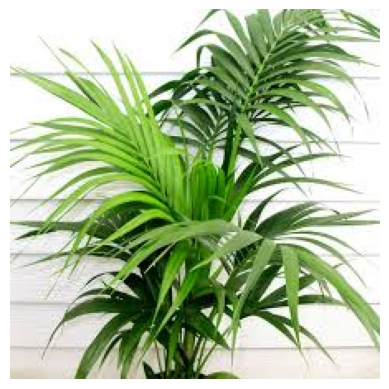

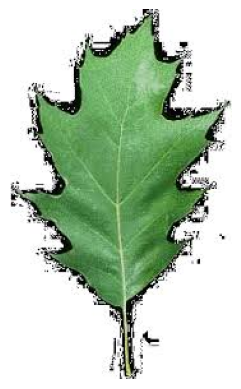

In [6]:
display_random_images(other)

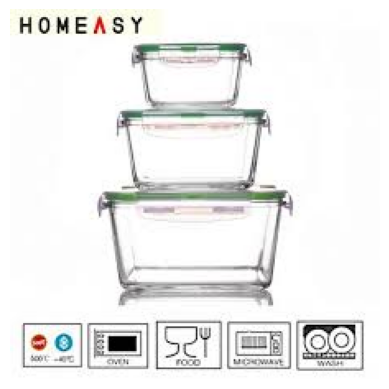

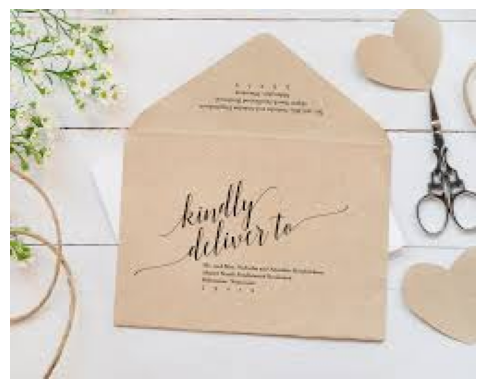

In [7]:
display_random_images(recycle)

# Data Preprocessing

## Resize Image

Karena resolusi gambar yang berbeda-beda ukurannya, oleh karena itu saya ingin melakukan resize gambar dengan resolusi 200x200

In [8]:
new_base_dir = '/content/drive/MyDrive/assets/trash-data/new_data'
new_other = os.path.join(new_base_dir,'other')
new_recycle = os.path.join(new_base_dir,'recycle')
target_resolution = (200, 200)
target_image = 6000

In [9]:
def resize_image_opencv(input_path, output_path, target_resolution=(200, 200)):
  try:
    if not os.path.exists(output_path):
      img = cv2.imread(input_path)
      img = cv2.resize(img, target_resolution, interpolation=cv2.INTER_AREA)
      cv2.imwrite(output_path, img)
  except cv2.error as e:
    logging.error(f'Error processing {input_path}: {e}')

def move_and_resize_image(input_path, output_path):
  try:
    resize_image_opencv(input_path, output_path)
  except Exception as e:
    logging.error(f'Error processing {input_path}: {e}')

def move_and_resize_images(source_dir, destination_dir):
  os.makedirs(destination_dir, exist_ok=True)
  existing_files = set(os.listdir(destination_dir))

  for filename in os.listdir(source_dir):
    if not filename.endswith(('.jpg', '.jpeg', '.png')): continue

    input_path = os.path.join(source_dir, filename)
    output_path = os.path.join(destination_dir, filename)

    if filename not in existing_files:
      move_and_resize_image(input_path, output_path)

def process_images_in_parallel(source_dir, destination_dir):
  os.makedirs(destination_dir, exist_ok=True)
  existing_files = set(os.listdir(destination_dir))
  image_files = [filename for filename in os.listdir(source_dir) if filename.endswith(('.jpg', '.jpeg', '.png'))]

  with multiprocessing.Pool() as pool:
    pool.starmap(resize_image_opencv, [(os.path.join(source_dir, filename), os.path.join(destination_dir, filename)) for filename in image_files if filename not in existing_files])

In [10]:
# Resize Other
if len(os.listdir(new_other)) < target_image:
  move_and_resize_images(recycle, os.path.join(new_base_dir, 'recycle'))
  print("Resize dan penyimpanan selesai.")
else : print('Dataset sudah pernah di resize')

Dataset sudah pernah di resize


In [11]:
# Resize Recycle
if len(os.listdir(new_other)) < target_image:
  move_and_resize_images(other, os.path.join(new_base_dir, 'other'))
  print("Resize dan penyimpanan selesai.")
else : print('Dataset sudah pernah di resize')

Dataset sudah pernah di resize


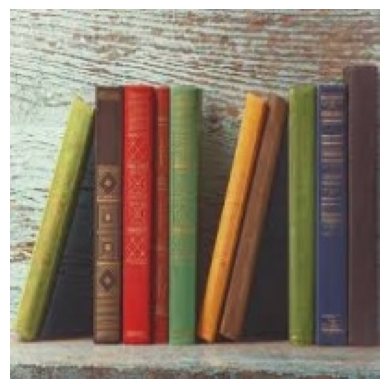

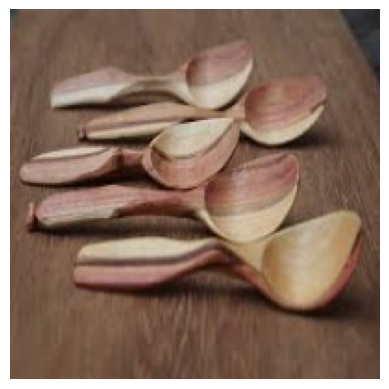

In [12]:
display_random_images(new_recycle)

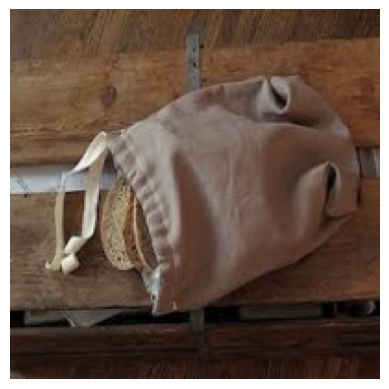

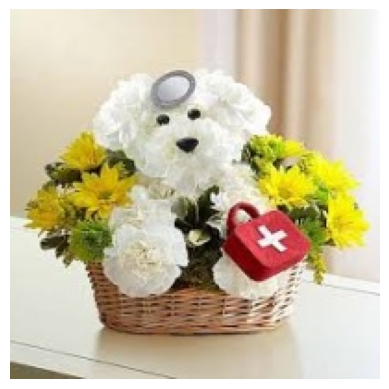

In [13]:
display_random_images(new_other)

## Selected Data
Karena terlalu banyaknya data sehingga proses training memakan waktu yang sangat lama, oleh karena itu saya mengambil 12000 dataset.
6000 dari kelas other dan 6000 dari kelas recycle

In [14]:
select_base = '/content/drive/MyDrive/assets/trash-data/select_data'
select_other = os.path.join(select_base, 'other')
select_recycle = os.path.join(select_base, 'recycle')

In [15]:
os.makedirs(select_other, exist_ok=True)
os.makedirs(select_recycle, exist_ok=True)

In [16]:
def copy_image(args):
  source_path, destination_path = args
  shutil.copyfile(source_path, destination_path)

def copy_images(source_dir, destination_dir, num_images):
  images = os.listdir(source_dir)
  selected_images = images[:num_images]

  args_list = []
  for image in selected_images:
    source_path = os.path.join(source_dir, image)
    destination_path = os.path.join(destination_dir, image)
    args_list.append((source_path, destination_path))

  with multiprocessing.Pool() as pool:
    pool.map(copy_image, args_list)

In [17]:
if len(os.listdir(select_recycle)) < target_image:
  copy_images(os.path.join(new_base_dir, 'recycle'), select_recycle, target_image)
  print("Select Image sudah selesai.")
else : print('Dataset sudah pernah di copy')

Dataset sudah pernah di copy


In [18]:
# Select Image kelas other
if len(os.listdir(select_other)) < target_image:
  copy_images(os.path.join(new_base_dir, 'other'), select_other, target_image)
  print("Select Image sudah selesai.")
else : print('Dataset sudah pernah di copy')

Dataset sudah pernah di copy


In [19]:
print(f'Jumlah dataset other: {len(os.listdir(select_other))}')
print(f'Jumlah dataset recycle: {len(os.listdir(select_recycle))}')

Jumlah dataset other: 6000
Jumlah dataset recycle: 6000


# Image Augmentation

In [20]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest',
    validation_split=0.2
)
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [21]:
train_data = train_datagen.flow_from_directory(
      select_base,
      target_size = target_resolution,
      class_mode = 'categorical',
      shuffle = True,
      batch_size = 50,
      seed = 42,
      subset = 'training'
      )

validation_data = validation_datagen.flow_from_directory(
      select_base,
      target_size = target_resolution,
      class_mode = 'categorical',
      shuffle = True,
      batch_size = 50,
      seed = 42,
      subset = 'validation'
      )


Found 9600 images belonging to 2 classes.
Found 2400 images belonging to 2 classes.


# Modeling
Saya menggunakan teknik transfer learning yang menggunakan model EfficientNetV2M

In [22]:
model = Sequential([
    EfficientNetV2M(weights="imagenet", include_top=False, input_tensor=Input(shape=(200,200,3))),
    Dropout(0.2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.2),
    Flatten(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-m (Function  (None, 7, 7, 1280)        53150388  
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 7, 7, 1280)        0         
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 64)          737344    
                                                                 
 max_pooling2d (MaxPooling2  (None, 2, 2, 64)          0         
 D)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 2, 2, 64)          0         
                                                                 
 flatten (Flatten)           (None, 256)               0

In [23]:
model.compile(
    loss='categorical_crossentropy',
    optimizer= Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

In [24]:
class MyCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('accuracy') >= 0.93) and (logs.get('val_accuracy') >= 0.93):
      print("\nReached 93% accuracy, stopping training")
      self.model.stop_training = True

callbacks = [
    EarlyStopping(monitor='val_accuracy'  , patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1),
    MyCallback()
]

In [25]:
history = model.fit(
    train_data,
    validation_data = validation_data,
    steps_per_epoch=32,
    epochs=100,
    validation_steps=17,
    verbose=2,
    shuffle=1,
    callbacks=callbacks
)

Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.50667, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 - 935s - loss: 0.7620 - accuracy: 0.6053 - val_loss: 0.7681 - val_accuracy: 0.5067 - 935s/epoch - 27s/step
Epoch 2/100

Epoch 2: val_accuracy improved from 0.50667 to 0.75833, saving model to best_model.h5
34/34 - 691s - loss: 0.5437 - accuracy: 0.7371 - val_loss: 0.5003 - val_accuracy: 0.7583 - 691s/epoch - 20s/step
Epoch 3/100

Epoch 3: val_accuracy improved from 0.75833 to 0.78333, saving model to best_model.h5
34/34 - 540s - loss: 0.4020 - accuracy: 0.8241 - val_loss: 0.4497 - val_accuracy: 0.7833 - 540s/epoch - 16s/step
Epoch 4/100

Epoch 4: val_accuracy improved from 0.78333 to 0.83833, saving model to best_model.h5
34/34 - 412s - loss: 0.3265 - accuracy: 0.8729 - val_loss: 0.3460 - val_accuracy: 0.8383 - 412s/epoch - 12s/step
Epoch 5/100

Epoch 5: val_accuracy improved from 0.83833 to 0.85500, saving model to best_model.h5
34/34 - 349s - loss: 0.2964 - accuracy: 0.8812 - val_loss: 0.4644 - val_accuracy: 0.8550 - 349s/epoch - 10s/step
Epoch 6/100

Epoch 6: val_accuracy impr

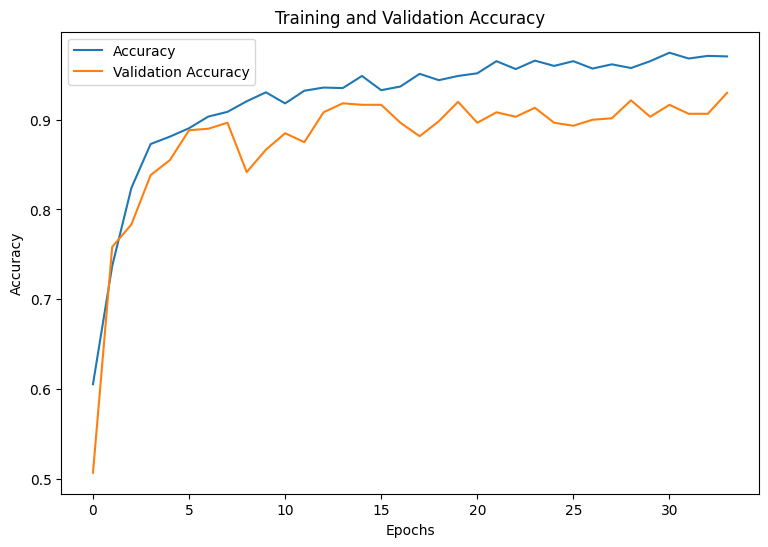

In [26]:
plt.figure(figsize=(9, 6))
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

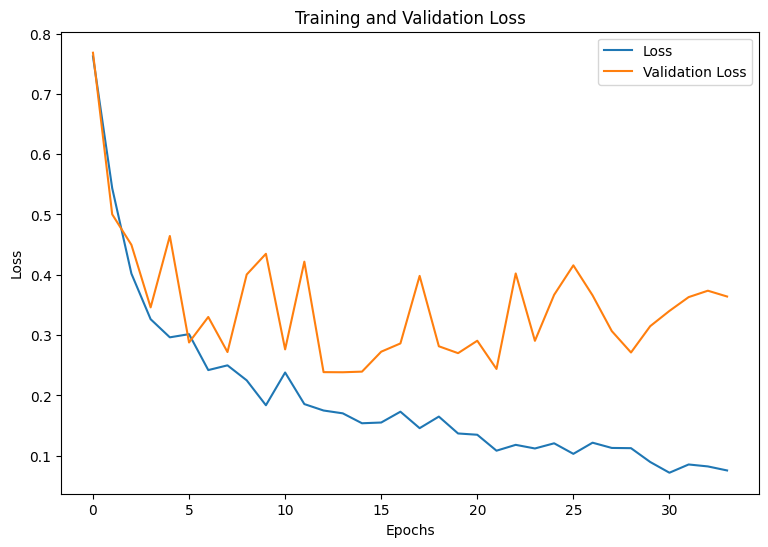

In [27]:
plt.figure(figsize=(9, 6))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Simple Test

Saving R_11.jpg to R_11.jpg
1/1 [==============================] - 7s 7s/step


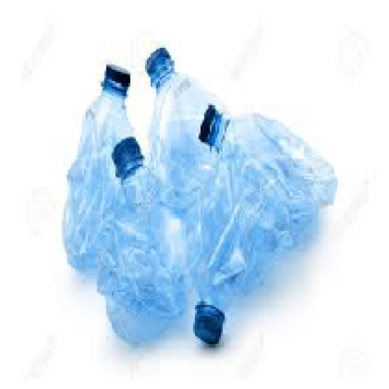


Prediction: Recycle


In [28]:
from google.colab import files
uploaded = files.upload() # upload file

model = load_model('best_model.h5')

for filename in uploaded.keys():
  path = filename
  img = load_img(path, target_size=(200, 200))
  img_array = img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array /= 255.0
  prediction = model.predict(img_array, batch_size=10)
  predicted_class = np.argmax(prediction, axis=1)
  plt.axis('off')
  plt.imshow(img)
  plt.show()

  if predicted_class == 0:
    print("\nPrediction: Other")
  elif predicted_class == 1:
    print("\nPrediction: Recycle")

# Convert to TFLite

In [29]:
my_model = load_model('best_model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(my_model)
tflite_model = converter.convert()

with open('best_model.tflite', 'wb') as f:
  f.write(tflite_model)